In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from typing import Tuple
from scipy.stats import t

In [18]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80 !important; }</style>"))

In [3]:
df = pd.read_csv("T_ONTIME_REPORTING.csv")

In [4]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'],
      dtype='object')

In [9]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()


def get_delays(df: pd.DataFrame, destinations, origins, confidence = 95, delay_type="ARR_DELAY"):
    overall_mean = df[delay_type].mean()
    overall_std = df[delay_type].std()

    df_filtered = df[df['DEST'].isin(destinations) & df['ORIGIN'].isin(origins)]
    mean_delays = pd.DataFrame(index=destinations, columns=origins)
    std_delays = pd.DataFrame(index=destinations, columns=origins)

    for (dest, origin), group in df_filtered.groupby(['DEST', 'ORIGIN']):
        data = group[delay_type].dropna()
        if len(data) > 1 and data.var() > 0:  # Ensure enough data points and non-zero variance
            stat, pvalue = ttest_1samp(data, overall_mean)
            mean_delays.at[dest, origin] = data.mean() if pvalue < (100-confidence)/100 else overall_mean
            std_delays.at[dest, origin] = data.std() if pvalue < (100-confidence)/100 else overall_std
        else:
            mean_delays.at[dest, origin] = overall_mean
            std_delays.at[dest, origin] = overall_std
    return mean_delays.fillna(overall_mean), std_delays.fillna(overall_std)


def get_delay_statistics(df, destinations, origins, confidence = 95):
    df['DELAY_DIFF'] = df['ARR_DELAY'] - df['DEP_DELAY']
    overall_std_diff = np.nanstd(df['DELAY_DIFF'])  # Use nanstd to ignore NaNs

    std_delay_diff = pd.DataFrame(index=destinations, columns=origins)
    for (dest, origin), group in df[(df['DEST'].isin(destinations)) & (df['ORIGIN'].isin(origins))].groupby(['DEST', 'ORIGIN']):
        data = group['DELAY_DIFF'].dropna()
        if len(data) > 1 and data.var() > 0:  # Check for sufficient data and variance
            stat, pvalue = ttest_1samp(data, overall_std_diff)
            std_delay_diff.at[dest, origin] = data.std() if pvalue < (100 -confidence)/100 else overall_std_diff
        else:
            std_delay_diff.at[dest, origin] = overall_std_diff

    return std_delay_diff.fillna(overall_std_diff)


mean_arr, std_arr = get_delays(df, destinations, origins)
mean_dep, _ = get_delays(df, destinations, origins, delay_type="DEP_DELAY")
mean_flight = mean_dep-mean_arr
std_delay_diff = get_delay_statistics(df, destinations, origins)
sample_size = df.groupby(['ORIGIN', 'DEST']).size().unstack(fill_value=0)

In [12]:
mean_arr
std_arr

,JFK,ORD,ABE,ATL,SGF,DTW,RDU,SYR,DSM,ICT,...,HTS,CKB,HGR,SMX,STC,PPG,OWB,ADK,LNK,PGV
BGR,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
ORD,57.396811,57.396811,10.926522,54.148002,57.396811,38.487821,34.564025,42.972879,114.164911,29.411875,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
JFK,57.396811,43.881753,57.396811,71.377142,57.396811,62.346795,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
ATL,57.396811,47.848747,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
SGF,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PPG,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
OWB,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
ADK,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811
LNK,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,...,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811,57.396811


In [19]:
tail_numbers = df.TAIL_NUM.unique()
keys = ["DEST", "ORIGIN", "ARR_TIME", "DAY_OF_MONTH"]

airport_names = df.DEST.unique()
airport_data = {}
for name in airport_names:
    airport_data[name] = []

print(len(tail_numbers))
for i, number in enumerate(tail_numbers):
    all_flights = df[df.loc[:, "TAIL_NUM"] == number]
    old_flight = pd.Series({"DEST": [np.NaN, np.NaN]})
    for month in all_flights.MONTH.unique():
        month_flights = all_flights[all_flights.loc[:, "MONTH"] == month]
        for day in month_flights.DAY_OF_MONTH.unique():
            flights = month_flights[month_flights.loc[:, "DAY_OF_MONTH"] == day]
            flights = flights.sort_values(by="ARR_TIME")
            for _, flight in flights.iterrows():
                if old_flight.DEST == flight.ORIGIN:
                    airport_data[flight.ORIGIN].append(flight.DEP_DELAY - flight.ARR_DELAY)
                old_flight = flight

5413


In [22]:
def sample_from_t(mean, std, n, size):
    if n > 1:  # Ensure there are enough samples to define a distribution
        df = n - 1  # Degrees of freedom
        scale = std / np.sqrt(n)  # Standard error of the mean
        return t.rvs(df, mean, scale, size=size)
    else:
        return np.nan  # Return NaN if not enough data points


# Create a new DataFrame to store the sampled values
flights_df = mean_flight.copy()
first_df = mean_flight.copy()


# Apply the sampling function to each element
for origin in flights_df.index:
    for dest in flights_df.columns:
        mean = mean_flight.at[dest, origin]
        std = std_delay_diff.at[dest, origin]
        n = sample_size.at[dest, origin]
        flights_df.at[dest, origin] = lambda size, mean=mean, std=std, n=n : t.rvs(n-1, mean, std, size=size)
        
        mean = mean_arr.at[dest, origin]
        std = std_arr.at[dest, origin]
        first_df.at[dest, origin] = lambda size, mean=mean, std=std, n=n : t.rvs(n-1, mean, std, size=size)

In [23]:
first_df.at["BOS", "JFK"](1)
# t.rvs(0, mean, n, size=1)

# for origin in origins:
#     for dest in destinations:
#         ans = first_df.at[dest, origin](1)
#         print(ans)
#         if ans is not np.NaN:
#             print(ans)

array([7.61824206])

In [24]:
ground = []
for airport in airport_data.keys():
    ground.extend(airport_data[airport])
arr = np.array(ground)
ground_mean = np.mean(arr[~np.isnan(arr)])


means = {}
std = {}
functions = {}
for airport in airport_data.keys():
    arr = np.array(airport_data[airport])
    clean_arr = arr[~np.isnan(arr)]
    if clean_arr.size > 0 :
        _, p_value = ttest_1samp(clean_arr, ground_mean)
        if p_value < 0.05:
            means[airport] = np.mean(clean_arr)
        else:
            means[airport] = ground_mean
        std[airport] = np.std(clean_arr)
        df, loc, scale = t.fit(clean_arr)
        functions[airport]  = lambda size: t.rvs(df, loc, scale, size=size) 
        # print(f"Airport = {airport}, delay = {functions[airport](1)}")
    else:
        means[airport] = ground_mean

# means_series = pd.Series(means)
# # Sorting the series in descending order by value
# sorted_means = means_series.sort_values(ascending=False)

# # Selecting the top 20 entries
# top_20_airports = sorted_means.tail(20)

# # Plotting
# plt.figure(figsize=(12, 6))  # Larger figure size for clarity
# top_20_airports.plot(kind='bar', color='teal')  # Using a different color for distinction
# plt.title('Top 20 Airports by Average Value')
# plt.xlabel('Airport')
# plt.ylabel('Added Delay (Minutes)')
# plt.xticks(rotation=45)  # Rotate the labels to fit them nicely
# plt.tight_layout()  # Adjust subplots
# plt.show()

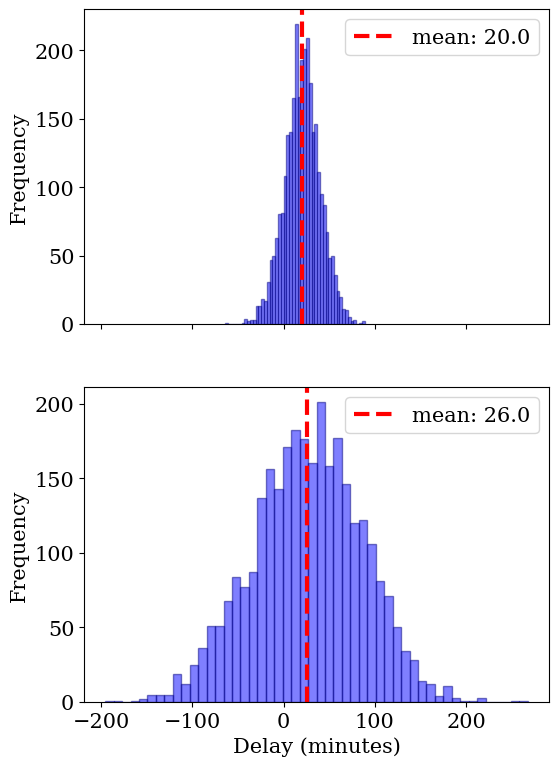

In [67]:
path = ["BOS", "JFK", "MIA"]

def calculate_expected_delay(path, means_series, mean_arr, mean_flight):
    expected_delay = 0
    for i in range(len(path) - 1):
        if i == 0:
            expected_delay += mean_arr.loc[path[i + 1], path[i]]
            
        else:
            expected_delay += means_series[path[i]]
            expected_delay += mean_flight.loc[path[i + 1], path[i]]
    return expected_delay

def distribution_delay(path, flights_df, first_df, functions, size, initial_state = None):
    delay = 0
    for i in range(len(path) - 1):
        if i == 0:
            if initial_state is not None:
                delay = initial_state
            else:
                delay = first_df.loc[path[i + 1], path[i]](size) 
        else:
            delay += functions[path[i]](size)
            delay += flights_df.loc[path[i + 1], path[i]](size)
    return delay

initial_state = 0
delay = distribution_delay(path, flights_df, first_df, functions, int(3e3), initial_state = initial_state)
delay2 = distribution_delay(path, flights_df, first_df, functions, int(3e3))
expected_delay = calculate_expected_delay(path, means, mean_arr, mean_flight)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15

path_label = path[0]
for i, airport in enumerate(path):
    if i != 0:
        path_label += ' -> ' + airport
# Plotting the histogram with a vertical line at the mean

fig, (ax0, ax1) = plt.subplots(2, 1, sharex = True, figsize=(6, 9))
ax0.hist(delay, bins=50, alpha=0.5, color='blue', edgecolor='navy')
ax0.axvline(np.mean(delay), color='red', linestyle='dashed', linewidth=3, label=f"mean: {np.round(np.mean(delay))}")
ax0.set_ylabel('Frequency')
ax0.legend()
ax1.hist(delay2, bins=50, alpha=0.5, color='blue', edgecolor='navy')
ax1.axvline(np.mean(delay2), color='red', linestyle='dashed', linewidth=3, label=f"mean: {np.round(np.mean(delay2))}")
ax1.set_xlabel('Delay (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend()
plt.tight_layout
plt.show()

In [ ]:
for dest in destinations:
    for origin in origins:
        print(first_df.at[dest, origin](1))


In [193]:
ground = []
for airport in airport_data.keys():
    ground.extend(airport_data[airport])
arr = np.array(ground)
ground_mean = np.mean(arr[~np.isnan(arr)])
print(ground_mean)

5.070214392943251


In [191]:
flight_delays = (df.ARR_DELAY - df.DEP_DELAY).dropna()
_, p_value = ttest_1samp(flight_delays, - ground_mean)
print(f"{100 * (1 - p_value)}")

527197
21.87321989367339


 .
 
 
 .
 
 
 .
 
 
 
 .
 
 
 
 
 .
 .
 .
 
 
 
 .
 
 
 
 
 .
 
 
 
 .
 
 
 
 
 
 .
 
 
 ..
 
 
 
 .
 
 
 
 
 .
 
 
 
 .
 
 
 
 
 
 
 .
 
 
 
 
 .
 
 
 
 
 
 
 .
 
 
 
 
 
 .
 
 
 
 
 
 
 
 .
 
 
 
 
 
 
 
 .
 
 
 
 
 
 .
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
  

In [43]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()

days = df.DAY_OF_WEEK.unique()
M_days = {}
P_days = {}
day_name = {1: "MON",
            2: "TUE",
            3: "WED",
            4: "THU",
            5: "FRI",
            6: "SAT",
            7: "SUN"
           }
for day in days:
    day = day_name[day]
    M, P = get_m_p(df.loc[df.DAY_OF_WEEK==day], destinations, origins)
    M_days[day] = M
    P_days[day] = P
print(M_days)
print(P_days)

{'SUN': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'MON': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'TUE': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'WED': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'TH

In [63]:
U_M, Sigma_M, VT_M = np.linalg.svd(M)
U_P, Sigma_P, VT_P= np.linalg.svd(P)
U_P[:, 0] * Sigma_P[0] @ VT_P[0,:]

76.82077498573389

In [79]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()

def get_influences(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    U, Sigma, VT = np.linalg.svd(A)
    
    # Create a correctly sized diagonal matrix for Sigma for multiplication
    Sigma_mat = np.zeros((U.shape[1], VT.shape[0]))
    np.fill_diagonal(Sigma_mat, Sigma)
    
    # Correctly perform the matrix multiplication
    origin_influences = VT @ Sigma_mat  # VT has dimensions n x n
    destination_influences = U @ Sigma_mat[:, :U.shape[1]]  # U has dimensions m x m

    # Calculating the norm of each scaled row/column to quantify influence
    origin_impacts = np.linalg.norm(origin_influences, axis=1)
    destination_impacts = np.linalg.norm(destination_influences, axis=0)
    
    return origin_impacts, destination_impacts

get_influences(M)

(array([ 496.40483418,  120.14709512,  161.28457281,  278.91501855,
         381.03034491,  308.02578393,  291.15433119,  248.66769888,
         459.04119268,  381.35273462,  350.88136362,  249.65838095,
         338.40559974,  298.74847298,  330.4442257 ,  363.84024044,
         274.27196192,  362.36663782,  267.52559523,  220.69015989,
         253.54138327,  347.97282128,  310.8921017 ,  516.78816465,
         324.75010802,  392.11975393,  491.1476317 ,  677.02289888,
         253.82226641,  565.34303925,  613.8994134 ,  437.66773526,
         458.9679591 ,  516.73306716,  545.42117801,  650.58217195,
         360.46281423,  853.53760753,  523.34780149,  812.25028242,
         621.60323459,  587.91454798,  397.03423391,  496.19695448,
         544.24094373,  287.72158785,  391.58148559,  666.15216772,
         393.61853437,  530.3024898 ,  496.45285517,  476.50891792,
         349.75232472,  417.47658179,  392.53456676,  584.37666622,
         333.99417242,  489.76344473,  581.86381

In [64]:
U_P

array([[ 7.70988534e-05,  1.22652147e-04, -1.07436212e-04, ...,
        -8.15597889e-04, -1.39359397e-04,  1.10131640e-01],
       [-7.41357073e-03,  2.88788905e-03,  3.76487660e-02, ...,
         1.35525272e-20, -6.09863722e-19, -9.54097912e-18],
       [-1.02627702e-02,  3.84530714e-03,  5.95655791e-03, ...,
         1.08631975e-18,  7.78635037e-19,  2.09305229e-16],
       ...,
       [ 1.43785671e-05, -6.57720790e-05, -2.24640123e-05, ...,
         3.02665876e-03, -1.17161705e-03, -5.60409062e-04],
       [-5.36060210e-05,  1.51990172e-04,  3.48541904e-04, ...,
        -4.74604268e-03, -1.19387852e-03, -2.87010053e-03],
       [ 1.09709265e-04, -3.57105103e-05, -9.50954448e-05, ...,
        -1.20613689e-03, -1.78338993e-03,  1.56421951e-03]])

In [92]:
tail_numbers = df.TAIL_NUM.unique()

for number in tail_numbers:
    flights = df[df.loc[:, "TAIL_NUM"] == tail_1.loc[:, ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME"]]
    




df[df.loc[:, "TAIL_NUM"] == tail_1.loc[:, ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME"]]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME
0,1,1,7,JFK,BGR,2236
1,1,1,7,JFK,ORD,1144
2,1,1,7,ORD,JFK,1841
15856,1,2,1,BGR,JFK,700
15857,1,2,1,BNA,JFK,1726
...,...,...,...,...,...,...
503456,1,30,1,TYS,LGA,1759
521656,1,31,2,JFK,CHS,2134
521657,1,31,2,JFK,ORF,1513
521658,1,31,2,MKE,JFK,1256
